In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
data = pd.read_csv('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Data/data.csv')

## 1. Data Exploring

In [4]:
# libraries
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# shape of the data
print("The row and the column of the data are: {0} rows and {1} columns".format(data.shape[0], data.shape[1]))

The row and the column of the data are: 304374 rows and 25 columns


---
We have 304,375 row tweets and other information about the disaster. 

Tweets are extracted between 2020-01-21 and 2020-01-27. 

Hashtags used: #deprem OR #elazig

***The earthquake happened in Elazig, in 2020-01-24 around 19:50.***

---

*The ratio of retweeted tweets:*

In [6]:
#The percentage of tweets from the initial set that are #retweets:
retweets = data[data['retweet'] == True]
print(f"The percentage of retweets is {round(len(retweets)/len(data)*100)}% of all the tweets")

The percentage of retweets is 0% of all the tweets


There are no retweet tweets. This may result from a problem of the API, or in the disaster moment, people tend to speak their own words, instead of forwarding other people's words.

---

*The ratio of mentioned tweets :*

To do that, first, I delete the "[]" characters, and then look for each cell, if the cell is not empty that means there is a mention.

In [7]:
#The percentage of tweets from the initial set that are replies to tweets of another user:
data['mentions'] = data['mentions'].replace("[]",int(0))
mentions = data[data['mentions'].apply(type) == str]
print(f"The percentage of mentions is {round(len(mentions)/len(data)*100)}% of all the tweets")

The percentage of mentions is 8% of all the tweets


---

*The ratio of no mention and no retweeted tweets:*

In [8]:
#See how many tweets inside are plain text tweets (No RT or mention)
plain_tweets = data[~data['tweet'].str.contains("@")  & ~data['tweet'].str.contains("RT")]
print(f"The percentage of plain text is {round(len(plain_tweets)/len(data)*100)}% of all the tweets")

The percentage of plain text is 94% of all the tweets


From the info function, we can see which columns should efinetely deleted since there is no data to analyze.

## 2. Text Cleaning

---

For the text column, we will create a function where delete the unwanted text or characters given in the function parameter. These cleaning will help us to get pure text to analyze and visualize the text data in the future. The text cleaning part will be as follows:

1. mention removal: e.g. @user
2. http link removal: e.g. https://twitter.com
3. lowercase: e.g. Ali İstanbul'a geldi. --> ali istanbul'a geldi.
4. numeric & punctuation removal: e.g. İstanbul'da 7 tepe vardır. --> istanbulda tepe vardır.
5. stopwords removal: e.g. Ayşe ile Mehmet için bir hediye alacagım. --> Ayşe Mehmet hediye alacagım.

Once we run all of them all these 5 issueas will be done. As an example:

**Before:** Ali ve Ayşe ile Veli'den 2 tane hediye aldık. @veli sağolsun bize bu mükemmel siteyi önerdi: https://abc.com

**After:** ali ayşe veliden hediye aldık sağolsun bize mükemmel siteyi önerdi

---

In [8]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=1ae04cbd1783fb6b796a8ff010c1fd4ef4e45705eaf9d8ce13aaf13ef7e50e31
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
# removing function
def removing(text, data):
    delete = re.findall(data, text)
    for each in delete:
        text = re.sub(each, '', text)
    return text

In [10]:
%%time
# @ mention removal
data['tidy_tweet'] = np.vectorize(removing)(data['tweet'], "@[\w]*") 

# http link removal
data['tidy_tweet'] = np.vectorize(removing)(data['tidy_tweet'], "http[\w]*")

# lowercase characters
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: x.lower())

# numeric, punctuation removal
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-ZüöşğıçİÇÖŞÜĞ#]", " ") 

# arranging the rows
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split()]))

# stop words removal
from stop_words import get_stop_words

stop_words = get_stop_words('turkish')
stop_words += ['geçmiş', 'gecmis','olsun','ol','nasıl','birşey','şu','altı','şeyden','şey','altmış','onların','kırk', 'mi', 'için','dk',
              'pic','twitter','http']

data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

CPU times: user 15.8 s, sys: 1.59 s, total: 17.4 s
Wall time: 17.4 s


## 3. Visualization

In [0]:
# loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

### 3.1. Tweet lengths

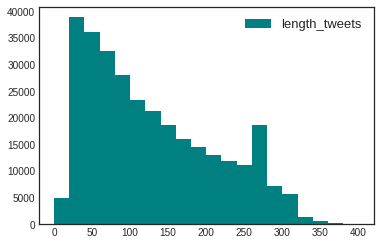

In [12]:
# distribution of length of the tweets, in terms of words
#print(plt.style.available)
length_tweets = data['tweet'].str.len() 
plt.style.use('seaborn-white')
plt.hist(length_tweets, bins=20, label="length_tweets", range=(0,400), color='#008080')
# plt.title('Distribution of Length of the Tweets', fontsize=15, weight = 'bold')
plt.legend(fontsize=13) 
plt.savefig('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Distribution of Length of the Tweets.png',format='png')
plt.show()

---

### 3.2. Word Clouds

After cleaning all noisy characters from the texts, we will look for the word cloud to see most repetitive words. I have added some additional "stop words" (e.g. ["twitter","elazig","deprem"..]) since we are looking for more extraordinary words.

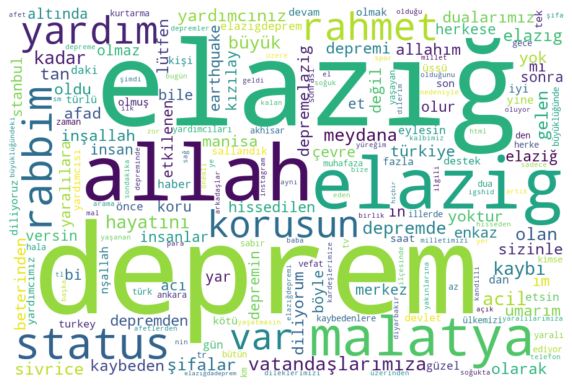

CPU times: user 7.28 s, sys: 217 ms, total: 7.5 s
Wall time: 7.51 s


In [13]:
%%time
all_words = ' '.join([text for text in data['tidy_tweet']]) 

wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(all_words)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
# plt.savefig("Word Cloud of Tweets.png", format='png')
plt.show()

---

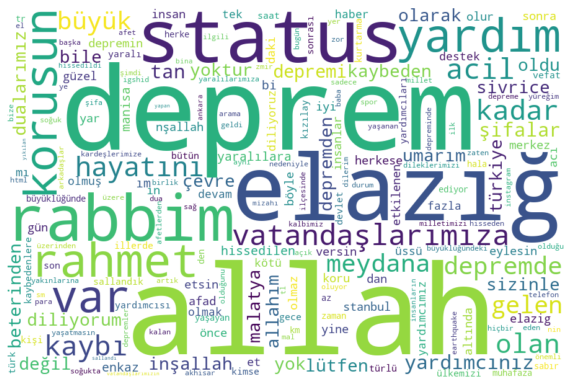

CPU times: user 11 s, sys: 261 ms, total: 11.2 s
Wall time: 11.7 s


In [14]:
%%time
# hashtag removal
data['no_hash_tweet'] = np.vectorize(removing)(data['tidy_tweet'], "#[\w]*")
all_words2 = ' '.join([text for text in data['no_hash_tweet']])

# collocations : removes repetitive shows
wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(all_words2)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Word Cloud of Tweets.png", format='png')
plt.show()

---

### 3.3. Hashtag Visualization

To understand the impact of Hashtags on tweets, we will create a function that extracts the hashtags from the tweets and count them. 

In [16]:
%%time
# function to collect hashtags 
def hashtag_extract(x):    
    hashtags = []    
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags

# extracting hashtags from tweets 
HT_list = hashtag_extract(data['tidy_tweet']) 
# unnesting list 
HT_list = sum(HT_list,[])

CPU times: user 19min 34s, sys: 3min 52s, total: 23min 27s
Wall time: 23min 23s


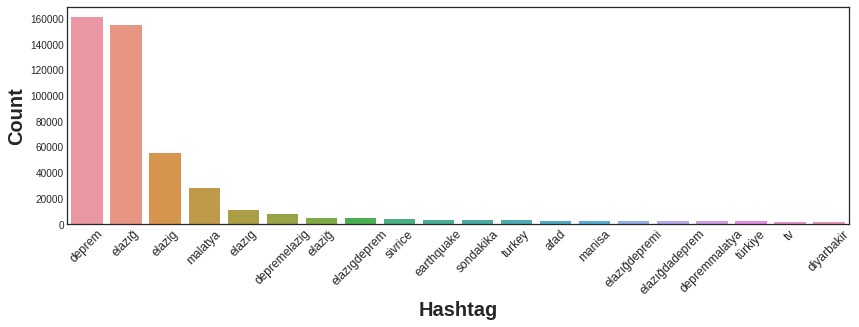

CPU times: user 1.07 s, sys: 11.7 ms, total: 1.08 s
Wall time: 1.1 s


In [17]:
%%time
a = nltk.FreqDist(HT_list)
d = pd.DataFrame({'Hashtag': list(a.keys()),                  
                  'Count': list(a.values())}) 

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(14,4)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count") 
ax.set_ylabel('Count', fontsize=20, fontweight='bold')
ax.set_xlabel('Hashtag', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/The 20 Most Used Hashtags.png", format='png',bbox_inches='tight')
plt.show()

---

The 20 Most Used Hashtags after we clean the extremely used ones. ['deprem','elazığ','elazig','malatya','elazıg'].


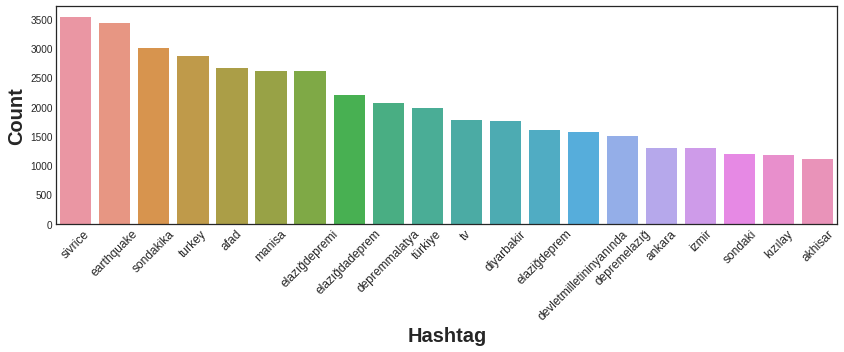

CPU times: user 1.03 s, sys: 13.9 ms, total: 1.05 s
Wall time: 1.39 s


In [18]:
%%time
#HT_regular
a = nltk.FreqDist(HT_list)
b = dict((word, freq) for word, freq in a.items() if word not in ['deprem','elazığ','elazig','malatya','elazıg','depremelazig','elaziğ','elazıgdeprem','i','depremvergilerinerede'])
d = pd.DataFrame({'Hashtag': list(b.keys()),                  
                  'Count': list(b.values())}) 
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(14,4)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count") 
ax.set_ylabel('Count', fontsize=20, fontweight='bold')
ax.set_xlabel('Hashtag', fontsize=20, fontweight='bold')
plt.xticks(rotation=45,fontsize=12)
plt.savefig('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Hashtags after Arranging.png', format='png', bbox_inches='tight')
plt.show()

### 3.4. Mention Visualization

The same method will apply to mention visualization. With function, we will get mention frequency.

In [0]:
#Now we will do the same with the mentions:
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z_]+")
mention_matches = list(data['tweet'].apply(mention_pattern.findall))
mentions_dict = {}
for match in mention_matches:
    for singlematch in match:
        if singlematch not in mentions_dict.keys():
            mentions_dict[singlematch] = 1
        else:
            mentions_dict[singlematch] = mentions_dict[singlematch]+1

In [0]:
#Create an ordered list of tuples with the most mentioned users and #the number of times they have been mentioned
mentions_ordered_list =sorted(mentions_dict.items(), key=lambda x:x[1])
mentions_ordered_list = mentions_ordered_list[::-1]
#Pick the 20 top mentioned users to plot and separate the previous #list into two list: one with the users and one with the values
mentions_ordered_values = []
mentions_ordered_keys = []
for item in mentions_ordered_list[0:25]:
    mentions_ordered_keys.append(item[0])
    mentions_ordered_values.append(item[1])

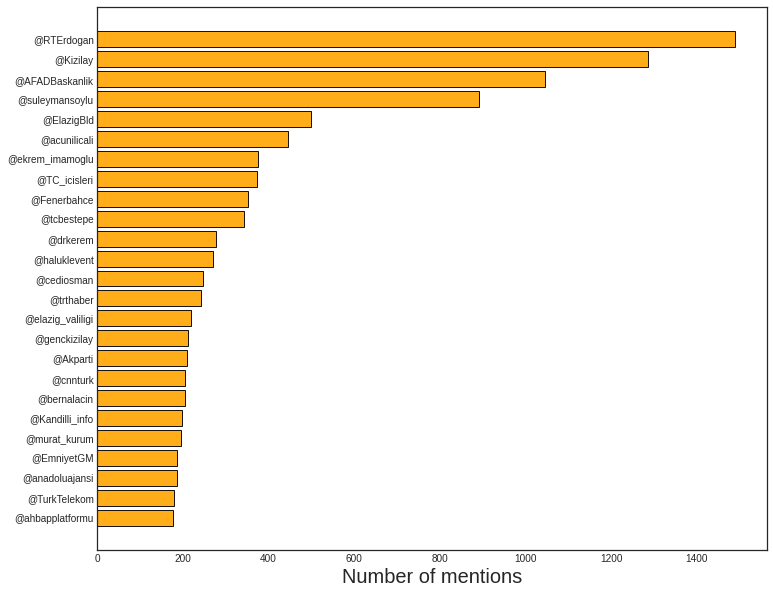

In [17]:
fig, ax = plt.subplots(figsize = (12,10))
y_pos = np.arange(len(mentions_ordered_values))
ax.barh(y_pos ,list(mentions_ordered_values)[::-1], align='center', color = 'orange',alpha=0.9, edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(mentions_ordered_keys)[::-1])
ax.set_xlabel("Number of mentions", fontsize = 20)
# ax.set_title("Most mentioned accounts", fontsize = 20)
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Users' Plotting/Most Mentioned Users.png", format='png',bbox_inches='tight')
plt.show()

The most mentioned users means somewhat in-degree centrality. With this knowledge, it is understandable that mostly govermental and well-known users have the higher frequency to get mention. A simple wordcloud of the mentioned users will be illustrated as below:

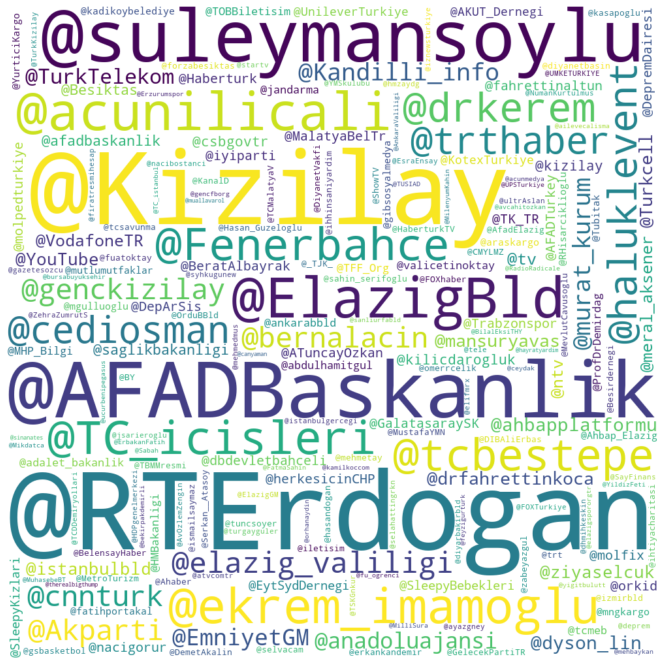

In [18]:
#Make a wordcloud representation for the most mentioned accounts too
mentions_ordered_dict = {}
for item in mentions_ordered_list:
    mentions_ordered_dict[item[0]] = item[1]
wordcloud = WordCloud(collocations=False, width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').\
generate_from_frequencies(mentions_ordered_dict)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
# plt.savefig('Word Cloud of most mentioned users.png', format = 'png')
plt.show()

### 3.5. Active Users

Just like mentioned users, active users also give an idea about social network analysis. It is explained as out-degree centrality since the users have more tweets and tags mpre people and they are generally socialable.

In [0]:
#Going to see who are the users who have tweeted or retweeted the #most and see how
#Likely it is that they are bots
usertweets = data.groupby('username')
#Taking the top 25 tweeting users
top_users = usertweets.count()['tweet'].sort_values(ascending = False)[:25]
top_users_dict = top_users.to_dict()
user_ordered_dict =sorted(top_users_dict.items(), key=lambda x:x[1])
user_ordered_dict = user_ordered_dict[::-1]
#Now, like in the previous hashtags and mention cases, going to make #two lists, one with the username and one with the value
dict_values = []
dict_keys = []
for item in user_ordered_dict[0:25]:
    dict_keys.append(item[0])
    dict_values.append(item[1])
dict_keys = ["@"+each for each in dict_keys]

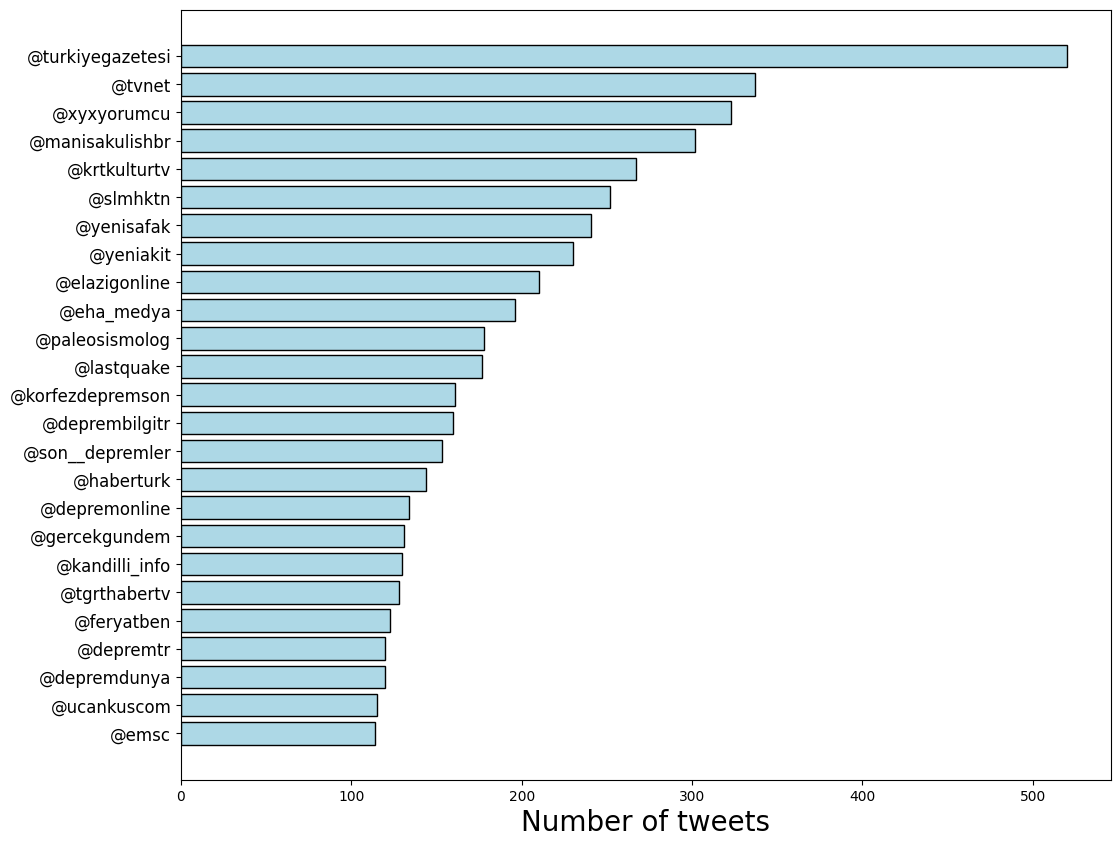

In [20]:
#Plot these results
plt.style.use('default')
fig = plt.figure(figsize = (12,10))
index = np.arange(25)
plt.barh(index, dict_values[::-1],color="lightblue", edgecolor = 'black', linewidth=1)
plt.xlabel('Number of tweets', fontsize = 20)
plt.yticks(index,dict_keys, fontsize=12)
# plt.title('Number of tweets for the most active users', fontsize = 20)
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Users' Plotting/Tweets_of_active_users.png", format='png',bbox_inches='tight')
plt.show()

## 4. Time Series

In [0]:
data['timestamp'] = data['date'] + " " + data['time']
data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format = "%d/%m/%Y", utc  = False)

def giveday(timestamp):
    day_string = timestamp.day
    return day_string

data['day'] = data['timestamp'].apply(giveday)
days = data.groupby('day')
daycount = days['tweet'].count()
timedict = daycount.to_dict()

### 4.1. Daily Tweet Number

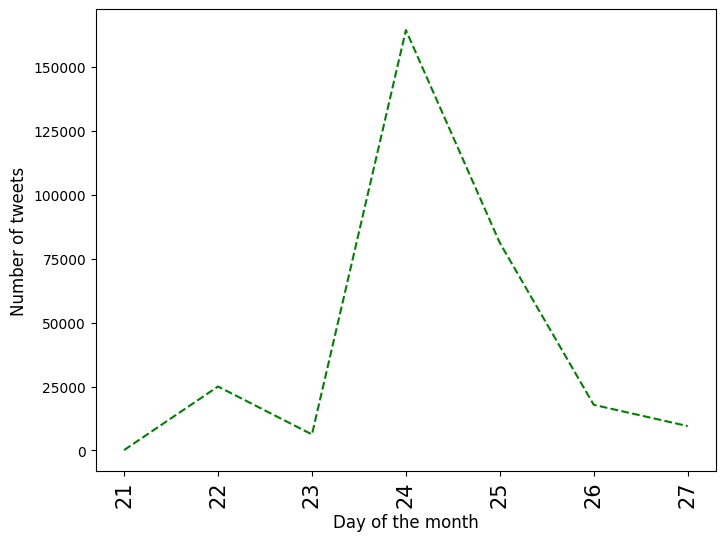

In [27]:
fig = plt.figure(figsize = (8,6))
plt.plot(list(timedict.keys()), list(timedict.values()), color='g', linewidth = 1.5, linestyle = '--')
plt.xlabel('Day of the month', fontsize = 12)
plt.ylabel('Number of tweets', fontsize=12)
plt.xticks(list(timedict.keys()), fontsize=15, rotation=90)
# plt.title('Number of Tweets per Day', fontsize = 15)
plt.savefig('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Time Series Plotting/Number of Tweets per Day')
plt.show()

In [29]:
trend = pd.read_csv('multiTimeline.csv', encoding= 'unicode_escape', names=['day','deprem','elazığ','elazig'])
trend.head()

day  deprem  elazığ  elazig
0  15-01       1       1       1
1  16-01       1       1       1
2  17-01       1       1       1
3  18-01       1       1       1
4  19-01       1       1       1

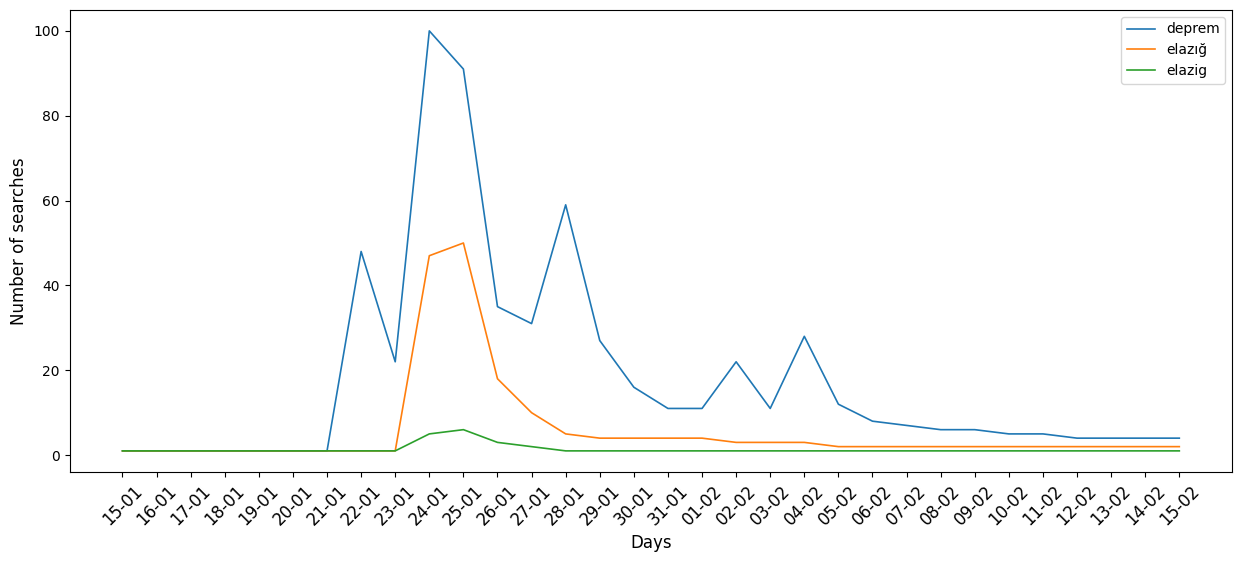

In [84]:
fig = plt.figure(figsize = (15,6))
plt.plot(trend['day'], trend['deprem'],linewidth = 1.2)
plt.plot(trend['day'], trend['elazığ'],linewidth = 1.2)
plt.plot(trend['day'], trend['elazig'],linewidth = 1.2)
plt.xlabel('Days', fontsize = 12)
plt.ylabel('Number of searches', fontsize=12)
plt.xticks(trend['day'], fontsize=12, rotation=45)
plt.legend(['deprem','elazığ','elazig'])
# plt.title('Number of Tweets per Day', fontsize = 15)
plt.savefig('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Time Series Plotting/Google Trend Search')
plt.show()

---

In [59]:
%%time
data['date-time'] = data['date']+" "+data['time']
data['date-time'] = pd.to_datetime(data['date-time'])
data_time = data.copy()
data_time = data_time.set_index('date-time')

CPU times: user 26.2 s, sys: 14.2 ms, total: 26.2 s
Wall time: 26.2 s


### 4.2. Tweets per 5 Minutes

In [0]:
data_time['deprem'] = data_time['tidy_tweet'].str.contains('deprem')
data_time['elazig'] = data_time['tidy_tweet'].str.contains('elazığ|elazig')

deprem = data_time['deprem'].resample('5 min').sum()
elazig = data_time['elazig'].resample('5 min').sum()

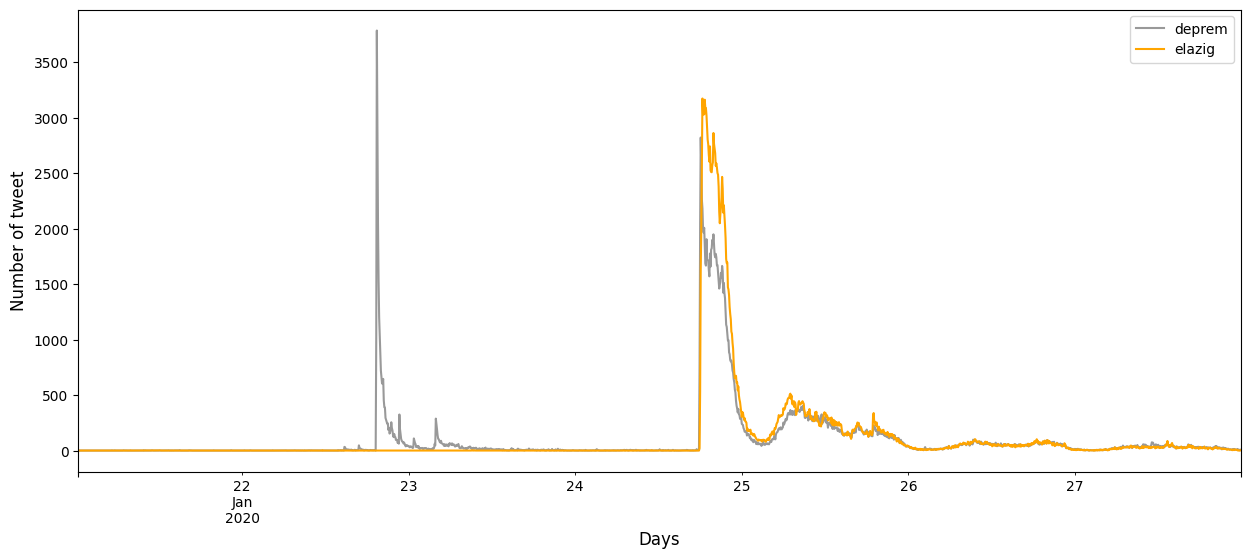

In [88]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(15, 6))

deprem.plot(color='0.6',linewidth=1.5)
elazig.plot(color='orange',linewidth=1.5)

plt.xlabel('Days', fontsize=12)
plt.ylabel('Number of tweet', fontsize=12)
plt.legend(('deprem','elazig'))
plt.savefig('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Time Series Plotting/Tweet distribution for the keywords per 5 mins')
plt.show()

**More than one earthquake occurred in Manisa on January 23. Therefore, the "earthquake" keyword of that day was used much more. On the 24th of January, the day of the earthquake in Elazig, both the "earthquake" and "elazig" words appear less because they address the same earthquake.**

---

### 4.3. Tweets per Minute

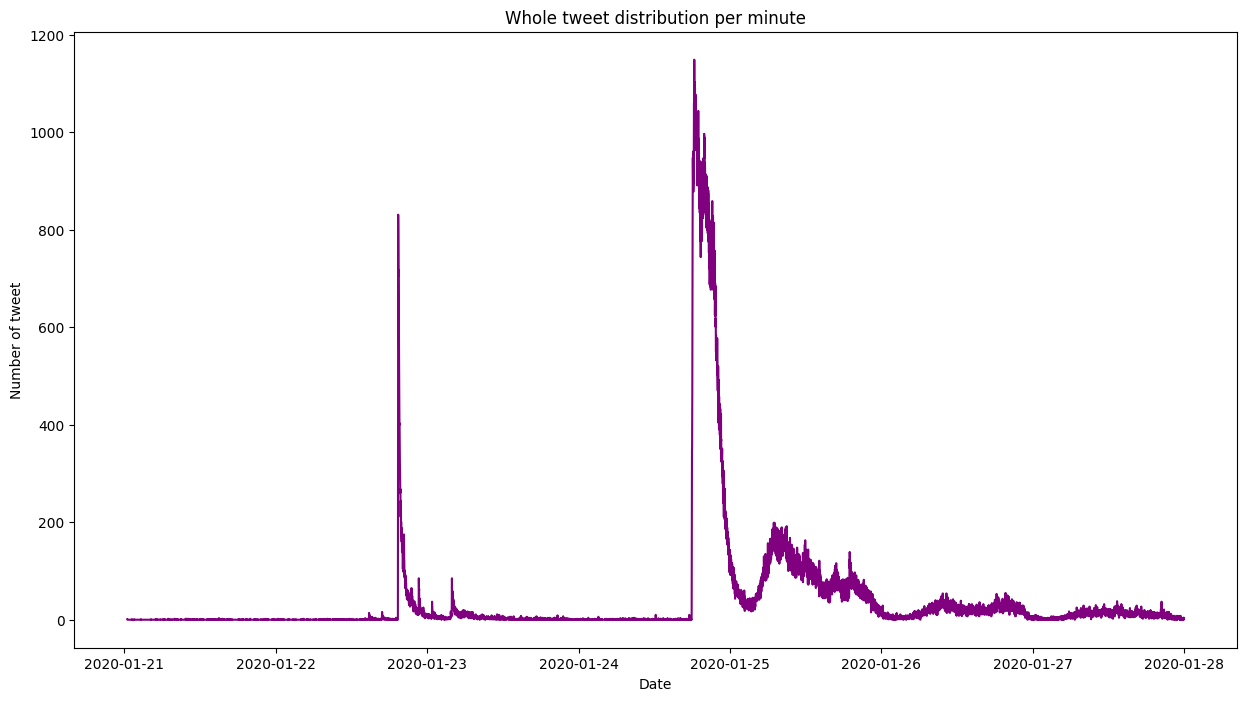

In [89]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(15, 8))

data_daily = data_time.resample('1 min').sum()

ax.plot(data_daily.index.values,
           data_daily['deprem']+data_daily['elazig'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Number of tweet",
       title="Whole tweet distribution per minute")

plt.show()

**In January 24 evening time, the tweet numbers are extremely high. We were expectig this since the earthquake happened in the 7 pm.**

---

In [90]:
# counting the words
deprem1 = data['tidy_tweet'].str.contains('deprem|earthquake', case = False)
elazig1 = data['tidy_tweet'].str.contains('elazığ|elazig', case = False)
print('the proportion of "deprem" word among th all dataset: \t',np.sum(deprem1)/data.shape[0])
print('the proportion of "elazig" word among th all dataset: \t',np.sum(elazig1)/data.shape[0])

the proportion of "deprem" word among th all dataset: 	 0.6717098043853943
the proportion of "elazig" word among th all dataset: 	 0.769135997161387


With this calculation, we are looking whether people discuss about situation or location. So we can presume about the other disasterrs. Does location matter or not?

---

## 5. Data Preparation

To prepare the data, we will get through some cleaning and adding columns. We are looking for the relation between user and their reply_to. So data['reply_to'] column is very important to us and we need to arrange that part as well. We need row by row for each user and their reply_to.

In [91]:
## Hashtag ekleme

def elazig(input_str):
    if "elazig" in input_str or "elazığ" in input_str or "elezig" in input_str or "elaziğ" in input_str or 'elazıg' in input_str or 'elaz' in input_str:
        return "#elazig"
    else:
        return ''
def deprem(input_str):
    if "deprem" in input_str or "dprm" in input_str or "deprm" in input_str or "dprem" in input_str or "zelzele" in input_str or\
    'zerzele' in input_str or 'yikim' in input_str or 'afet' in input_str or 'yıkım' in input_str:
        return "#deprem"
    else:
        return ''

    
data.loc[:, 'elazig-tags'] = data.hashtags.apply(elazig)
data.loc[:, 'deprem-tags'] = data.hashtags.apply(deprem)
data["tags"] = data["elazig-tags"] + "," + data["deprem-tags"]    

data.tags.value_counts()

#elazig,           134335
#elazig,#deprem     90685
,#deprem            78638
,                     716
Name: tags, dtype: int64

In [0]:
# photos sutununda link varsa 1, yoksa 0 olarak binary'e cevirdim:
data.loc[~data.photos.str.contains('\[]'),['photos']] = 1
data.loc[data.photos != 1,['photos']] = 0
data.photos = pd.to_numeric(data.photos)

In [93]:
data = data.drop([ 'username.1','user_rt_id', 'near', 'geo', 'source', 'retweet_date','elazig-tags','deprem-tags','retweet','link'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304374 entries, 0 to 304373
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   id               304374 non-null  float64       
 1   username         304374 non-null  object        
 2   conversation_id  304374 non-null  float64       
 3   date             304374 non-null  object        
 4   time             304374 non-null  object        
 5   timezone         304374 non-null  object        
 6   user_id          304374 non-null  float64       
 7   place            269 non-null     object        
 8   tweet            304374 non-null  object        
 9   mentions         304374 non-null  object        
 10  photos           304374 non-null  int64         
 11  replies_count    304374 non-null  int64         
 12  retweets_count   304374 non-null  int64         
 13  likes_count      304374 non-null  int64         
 14  hashtags         304

### 5.1. Preparing Graph Nodes, Edges & Attributes

In [94]:
%%time
data['Target'] = data['reply_to']

# user_id kismini goturuyoruz:
data.Target = data.Target.str.split(',')
data.Target = [[x for x in sub if 'user_id' not in x] for sub in data.Target]

# username kisiminda sadece "username"'i goturecegiz ki asil istedigimiz kullanici adi kalsin:
data['Target'] = data['Target'].apply(lambda x: str(x).split(":"))
data['Target'] = data['Target'].apply(lambda x: str(x).replace("username", ''))

# son olarak gereksiz karakterlerden kurtuluyoruz:
data['Target'] = data['Target'].apply(lambda x: str(x).replace('\\',''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace("""'""",''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace(',',''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace('}',''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace('[',''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace(']',''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace('''"''',''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace("""' '""",''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace('   ',','))
data['Target'] = data['Target'].apply(lambda x: str(x).replace(' ',''))
data['Target'] = data['Target'].apply(lambda x: str(x).replace("'",''))

# kücük harf yapıyoruz:
data['Target'] = data['Target'].apply(lambda x: x.lower())

CPU times: user 3.4 s, sys: 89 ms, total: 3.49 s
Wall time: 3.5 s


Expanding part: where we will add row for each reply_to users, if necessary.

In [0]:
def expand(df, col, sep=','):
    r = df[col].astype(str).str.split(sep)
    d = {c: df[c].values.repeat(r.str.len(), axis=0) for c in df.columns}
    d[col] = [i for sub in r for i in sub]
    return pd.DataFrame(d)

In [96]:
reply = expand(data,'Target')
print("The number of rows when we created binary interactions between username and reply: \t", len(reply))

reply.drop(reply.loc[reply['Target']==''].index, inplace=True)
print("The number of rows when we deleted empty reply cells: \t\t\t\t\t", len(reply))

reply.drop(reply.loc[reply['Target']==reply['username']].index, inplace=True)
print("The number of rows when we deleted identical username-reply rows: \t\t\t", len(reply))

The number of rows when we created binary interactions between username and reply: 	 657192
The number of rows when we deleted empty reply cells: 					 352818
The number of rows when we deleted identical username-reply rows: 			 48447


*Category Creation:*

In [0]:
earthquake = ['deprem','earthquake','quake','zelzele','emsc','kandilli','deparsis']
reply['earthquake_source'] = reply['username'].where(reply['username'].str.contains('|'.join(earthquake)))
reply['earthquake_target'] = reply['Target'].where(reply['Target'].str.contains('|'.join(earthquake)))

media = ["son","haber","medya","dakika",'gundem','gazete','info','ntv','tv','news','dergi','cnnturk','ajans']
reply['media_source'] = reply['username'].where(reply['username'].str.contains('|'.join(media)))
reply['media_target'] = reply['Target'].where(reply['Target'].str.contains('|'.join(media)))

person = ["zeynep", "elif","burak","mehmet","emre","ahmet","mustafa","ali","mert" ,"furkan","murat","fatih","can" , "onur" , "enes" , "kaan" ,
          "deniz","busra","beyza" , "gizem" , "esra" , "irem","ezgi","ceren","ece" , "gamze" , "selin" , "kubra" ,"betul" ,"merve",'omer' , 
          "ihsan" , "yunus","mehmet","efe","yeliz", "orhan", "meryem", "umut","muhammet",'muhammed','mahmut']
reply['person_source'] = reply['username'].where(reply['username'].str.contains('|'.join(person)))
reply['person_target'] = reply['Target'].where(reply['Target'].str.contains('|'.join(person)))

government = ['belediye','bld','bakanligi','vali','bakani','beltr','rterdogan','suleymansoylu','ekrem_imamoglu','mansuryavas06','bakan',
              'government','gov','parti']
reply['government_source'] = reply['username'].where(reply['username'].str.contains('|'.join(government)))
reply['government_target'] = reply['Target'].where(reply['Target'].str.contains('|'.join(government)))

institution = [ 'university','uni','universitesi','universite','okul','school','edu','univ']
reply['institution_source'] = reply['username'].where(reply['username'].str.contains('|'.join(institution)))
reply['institution_target'] = reply['Target'].where(reply['Target'].str.contains('|'.join(institution)))

In [0]:
reply.drop(['id', 'conversation_id', 'date', 'time', 'timezone','user_id', 'place', 'mentions','hashtags', 'reply_to','tidy_tweet', 'day', 
             'date-time'], axis=1, inplace=True)
reply.head()

In [0]:
reply.to_csv('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Data/graph-ready.csv')

### 5.2. Category Word Clouds

In [0]:
graph = pd.read_csv('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Data/Graph-SNA/graph.csv',encoding= 'utf8')
graph['text'] = list(reply['no_hash_tweet'])
graph.drop(['tidy_tweet'], axis=1, inplace=True)

In [119]:
graph.Category.value_counts()

Other            36910
Person            7368
Earthquake        1707
Media             1346
Institutional      682
Govermental        434
Name: Category, dtype: int64

Create list for each category:

In [0]:
other = graph[graph['Category']=='Other']
person = graph[graph['Category']=='Person']
media = graph[graph['Category']=='Media']
institutional = graph[graph['Category']=='Institutional']
earthquake = graph[graph['Category']=='Earthquake']
governmental = graph[graph['Category']=='Govermental']

### 5.2.1. "Other" Category Word Cloud

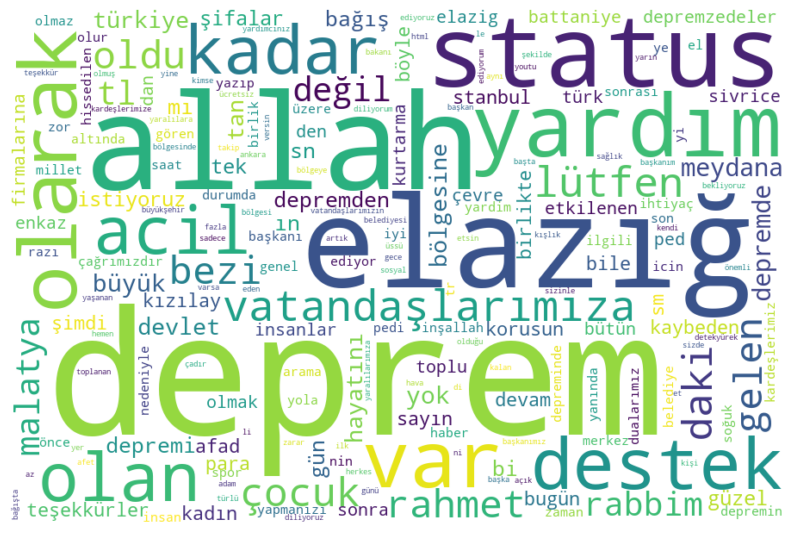

In [123]:
# collocations : removes repetitive shows
other_all = ' '.join([text for text in other['text']]) 

wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(other_all)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Tweets' Plotting/Category Word Cloud/other-cat-wc.png")
plt.show()

### 5.2.2. "Person" Category Word Cloud

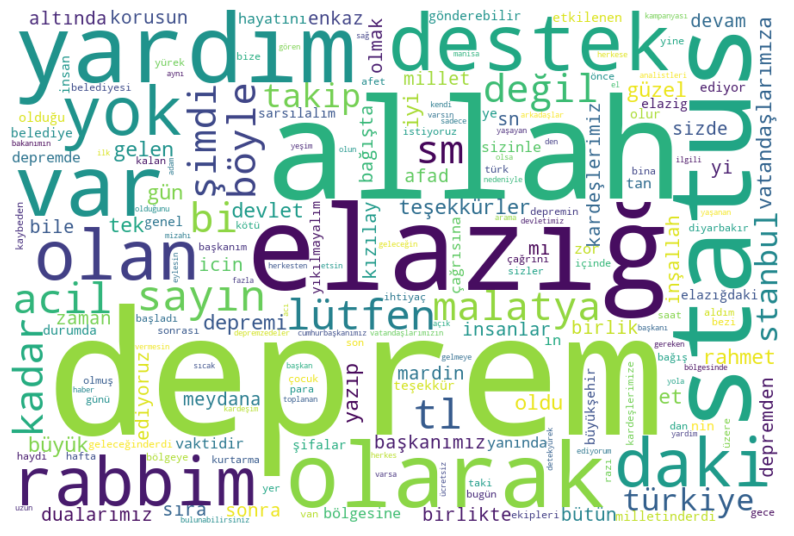

In [125]:
# collocations : removes repetitive shows
person_all = ' '.join([text for text in person['text']]) 

wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(person_all)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Tweets' Plotting/Category Word Cloud/person-cat-wc.png")
plt.show()

### 5.2.3. "Media" Category Word Cloud

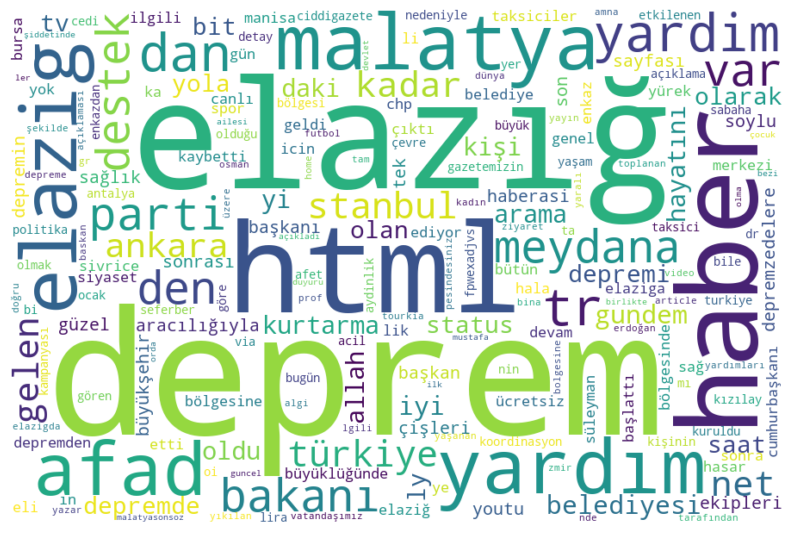

In [126]:
# collocations : removes repetitive shows
media_all = ' '.join([text for text in media['text']]) 

wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(media_all)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Tweets' Plotting/Category Word Cloud/media-cat-wc.png")
plt.show()

### 5.2.4. "Institutional" Category Word Cloud

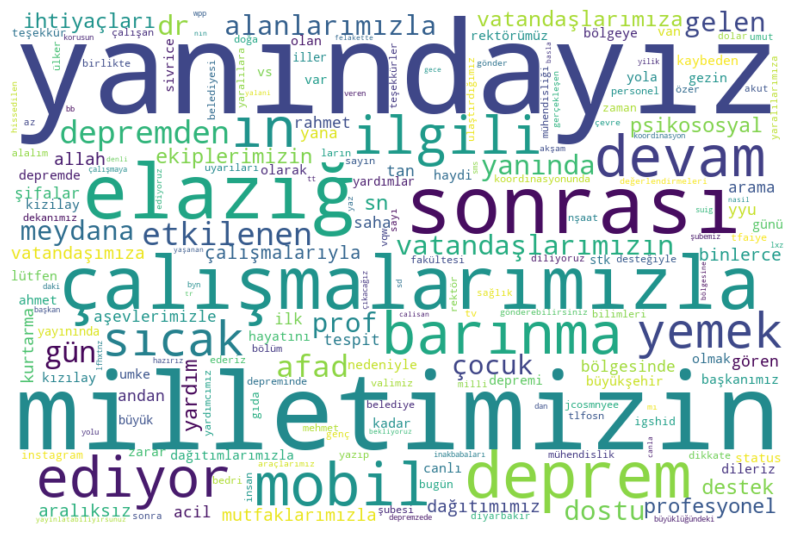

In [127]:
# collocations : removes repetitive shows
inst_all = ' '.join([text for text in institutional['text']]) 

wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(inst_all)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Tweets' Plotting/Category Word Cloud/instit-cat-wc.png")
plt.show()

### 5.2.5. "Earthquake" Category Word Cloud

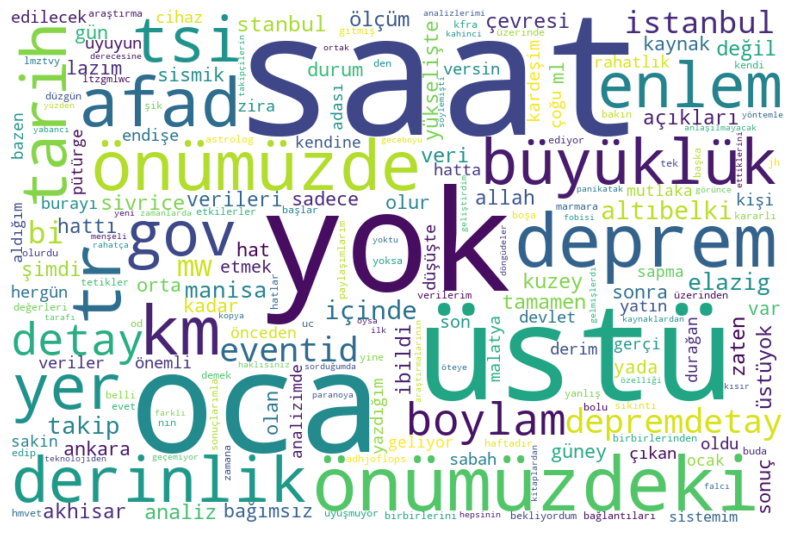

In [128]:
# collocations : removes repetitive shows
earth_all = ' '.join([text for text in earthquake['text']]) 

wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(earth_all)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Tweets' Plotting/Category Word Cloud/earth-cat-wc.png")
plt.show()

### 5.2.6. "Governmental" Category Word Cloud

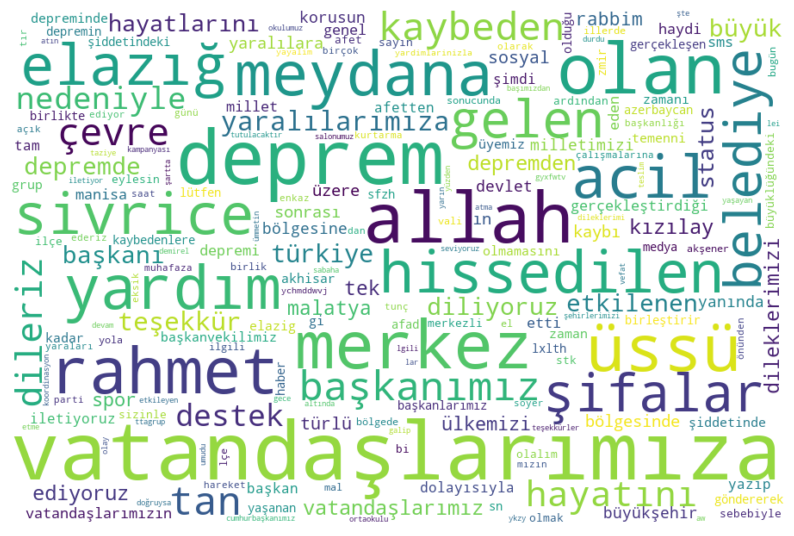

In [129]:
# collocations : removes repetitive shows
gover_all = ' '.join([text for text in governmental['text']]) 

wordcloud = WordCloud(collocations=False, width=900,height=600,max_words=200,random_state=25,max_font_size=200, 
                      background_color="white").generate(gover_all)
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Tweets' Plotting/Category Word Cloud/govern-cat-wc.png")
plt.show()

## 6. Graph & SNA

In [229]:
# cent = pd.read_csv('/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Data/Graph-SNA/elazig-centralities-filtresiz.csv')
import pandas as pd
cent = pd.read_csv('/content/elazig_filtresiz.csv')
cent.head()

Id           Label  timeset  ... eigencentrality  Unnamed: 19  1511
0    132        adayesat      NaN  ...        0.009073          NaN   NaN
1   4383     eyup_sagcan      NaN  ...        0.005405          NaN   NaN
2   4242     sirvanvural      NaN  ...        0.006814          NaN   NaN
3    734    kenan12_erol      NaN  ...        0.010066          NaN   NaN
4  14115  hayrolayasemin      NaN  ...        0.007610          NaN   NaN

[5 rows x 21 columns]

#### in degree - out-degree

In [0]:
import collections
indegree = collections.Counter(list(cent['indegree']))
outdegree = collections.Counter(list(cent['outdegree']))

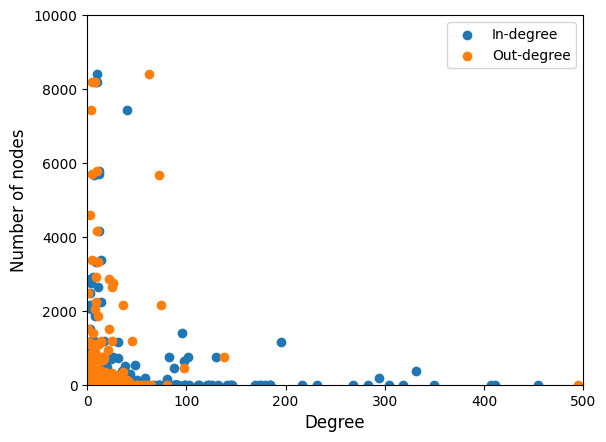

In [230]:
# bubble plot
plt.scatter(cent['indegree'],cent['betweenesscentrality'])
plt.scatter(cent['outdegree'],cent['betweenesscentrality'])

# plt.scatter(cent['outdegree'], cent['betweenesscentrality'])


plt.ylim(0, 10000)
plt.xlim(0,500)
plt.legend(['In-degree','Out-degree']) 
plt.xlabel('Degree', fontsize = 12)
plt.ylabel('Number of nodes', fontsize=12) 
# plt.title('In-degree & Out-degree Nodes Distribution') 
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/in&out_degree_distribution.png") 
plt.show()


#### Log-log Distribution 

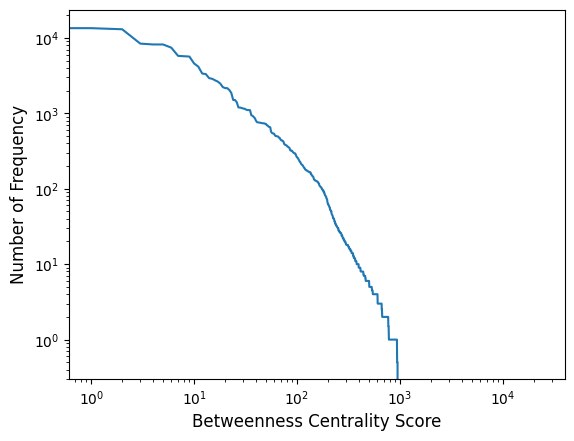

In [231]:
degree_sequence=sorted(cent['betweenesscentrality'],reverse=True) 
plt.loglog(degree_sequence)
plt.xlabel('Betweenness Centrality Score', fontsize=12)
plt.ylabel('Number of Frequency', fontsize=12) 
# plt.title('Betweenness Centrality Log-Log Distribution')
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/bc_loglog.png")
plt.show()

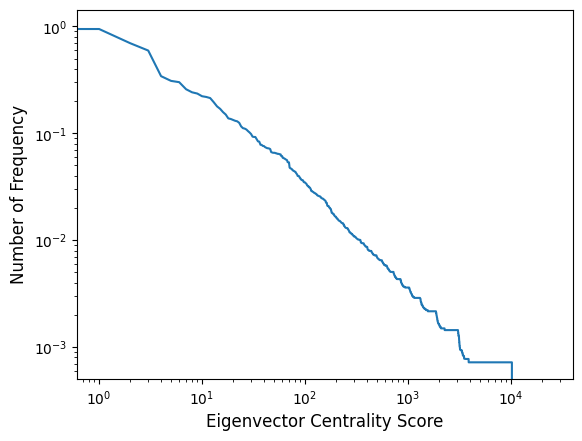

In [232]:
eigen_sequence=sorted(cent['eigencentrality'],reverse=True) 
plt.loglog(eigen_sequence)
plt.xlabel('Eigenvector Centrality Score',fontsize=12)
plt.ylabel('Number of Frequency',fontsize=12) 
# plt.title('Eigenvector Centrality Log-Log Distribution')
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/eigen_loglog.png")
plt.show()

In [235]:
cent.nlargest(100,'eigencentrality')[['category','eigencentrality']].groupby('category').sum()

eigencentrality
category                      
Earthquake            0.243358
Govermental           4.950268
Institutional         3.712620
Media                 0.817000
Other                 0.170342
Person                1.998738

### Category Based Centralities

<Figure size 900x1100 with 0 Axes>

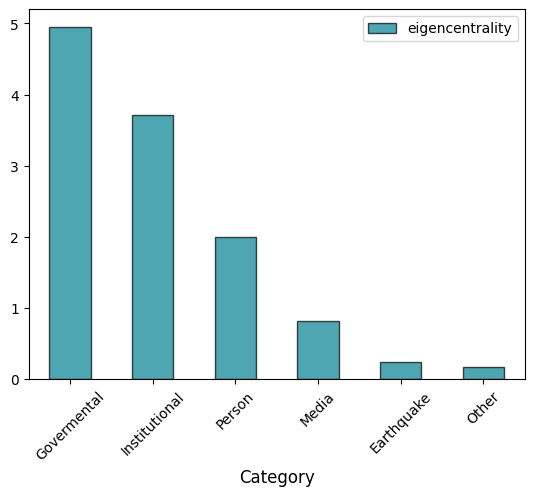

In [238]:
plt.figure(figsize=(9,11))
cent.nlargest(100,'eigencentrality')[['category','eigencentrality']].groupby('category').sum().reindex(['Govermental','Institutional',
                                                                                                       'Person','Media','Earthquake','Other']).plot.bar(
                                                                                                           color="#028090",alpha=0.7,
                                                                                                            edgecolor = 'black', linewidth=1
                                                                                                       )
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=45)
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/eigen-category-top100.png", bbox_inches='tight')

In [237]:
cent.nlargest(100,'betweenesscentrality')[['category','betweenesscentrality']].groupby('category').sum()

betweenesscentrality
category                           
Earthquake              1476.166667
Govermental             4800.783333
Institutional           5779.750000
Media                   6427.016667
Other                  89080.581350
Person                 69545.774602

<Figure size 900x1100 with 0 Axes>

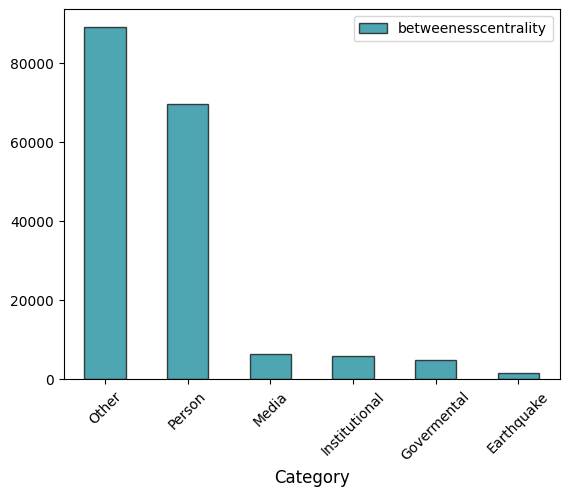

In [236]:
plt.figure(figsize=(9,11))
cent.nlargest(100,'betweenesscentrality')[['category','betweenesscentrality']].groupby('category').sum().reindex(['Other','Person','Media','Institutional',
                                                                                                       'Govermental','Earthquake']).plot.bar(
                                                                                                           color="#028090",alpha=0.7,
                                                                                                            edgecolor = 'black', linewidth=1
                                                                                                       )
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=45)
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/betweenness-category-top100.png", bbox_inches='tight')

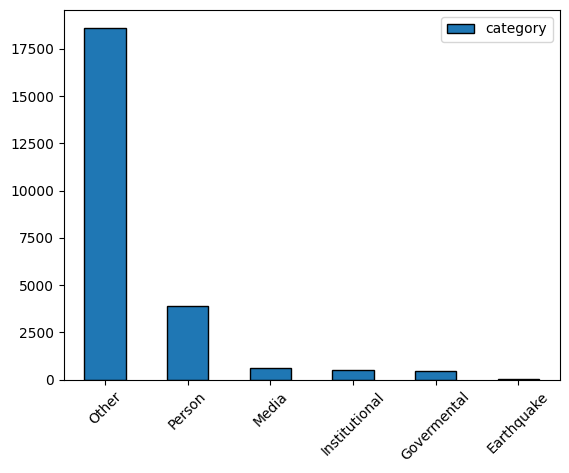

In [259]:
CountStatus = pd.value_counts(cent['category'].values, sort=True)
CountStatus.plot.bar(edgecolor = 'black', linewidth=1)
plt.xticks(rotation=45)
plt.legend(['category'])
plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/category-value_count.png", bbox_inches='tight')
plt.show()

#### Betweenness Centrality Top 20 with Usernames:

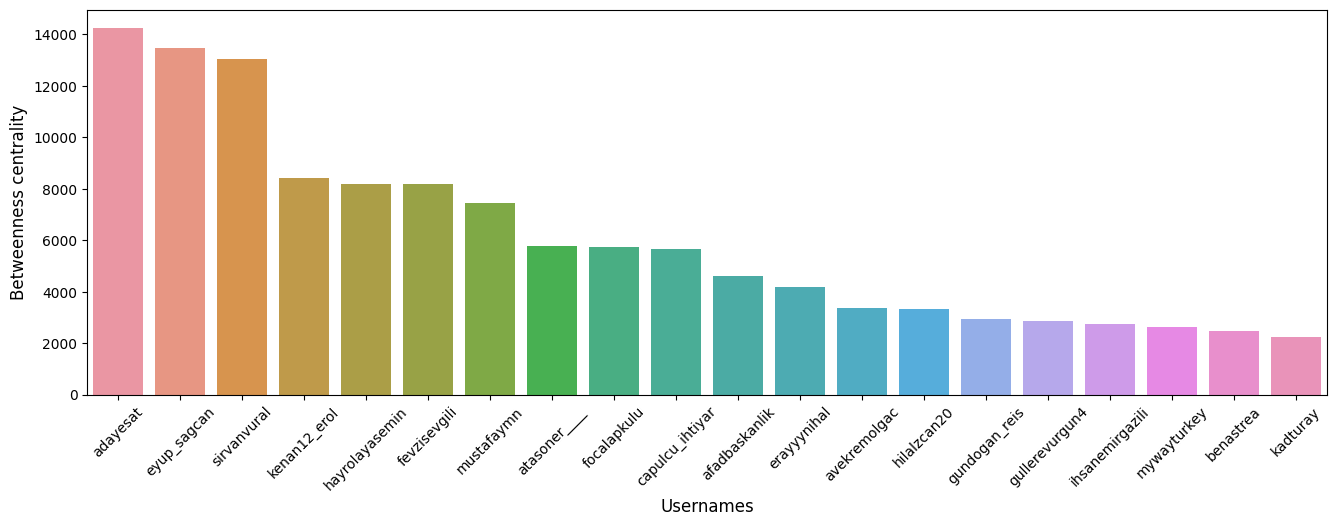

In [225]:
bc_data = cent.nlargest(columns="betweenesscentrality", n = 20)

plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=bc_data, x= "Label", y = "betweenesscentrality")
plt.ylabel('Betweenness centrality', fontsize=12)
plt.xlabel('Usernames', fontsize=12)
# plt.title('Betweenness Centrality Highest 20 Users')
plt.xticks(rotation=45)
# plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/betweenness-category-top100.png", bbox_inches='tight')
plt.show()

#### Eigenvector Centrality Top 20 with Usernames:

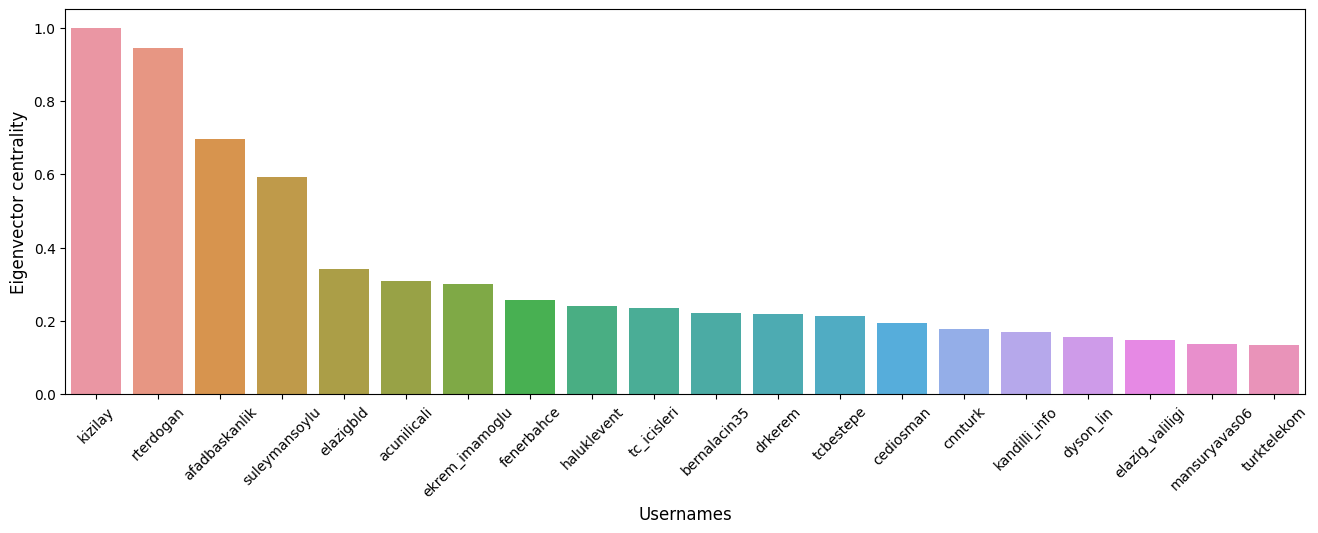

In [226]:
eigen_data = cent.nlargest(columns="eigencentrality", n = 20)

plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=eigen_data, x= "Label", y = "eigencentrality")
plt.ylabel('Eigenvector centrality', fontsize=12)
plt.xlabel('Usernames', fontsize=12)
# plt.title('Eigenvector Centrality Highest 20 Users')
plt.xticks(rotation=45)
# plt.savefig("/content/gdrive/My Drive/Gozde Merve Demirci Master Tez/Visualizations/Centralities/eigen-category-top100.png", bbox_inches='tight')
plt.show()